# Model Evaluation (Global Average Pooling)

We are now familiar with our data, so the next logical step is to explore the space of algorithms that will eventually yield a good model for the task we are trying to solve.

Our goal in this notebook is not to develop state of the art solutions, but rather spot-check several architectures in order to see which will be promoted to the next phase of the process, centered around model optimization. 

Without further ado, let's get to it!

## Spot-Checking

In order to evaluate a broad range of possible algorithms, we need to implement some functions first. Let's start by shaping our data the way we need it.

### Data

This function will give us the data relevant to the experiment in this notebook, which are the features generated by the Global Average Pooling Extractor. Notice we are just loading the resulting features saved to disk in `.npy` format.

In [1]:
import numpy as np

def load_dataset():
    X = np.load('global_average_features.npy')
    y = np.load('labels.npy')
    
    return X, y

In [2]:
X, y = load_dataset()

### Models

This function returns a wide range of models, from linear ones such as logistic regression, to tree based ones such as extra trees or even ensembles, like AdaBoost. We are also using a couple of different versions of the same underlying model, as in the case of KNeighborsClassifier, where we create a new instance for a different number of neighbors (starting at 1 up to 25)

It is important to mention that we are creating these models with the default values just to give them a fair chance of solving the problem. The optimization will come later for those models that are promising.

In [3]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

def define_models(models=dict()):
    models['LogisticRegression'] = LogisticRegression()
    models['SGDClassifier'] = SGDClassifier()
    models['PassiveAggressiveClassifier'] = PassiveAggressiveClassifier()
    models['DecisionTreeClassifier'] = DecisionTreeClassifier()
    models['ExtraTreeClassifier'] = ExtraTreeClassifier()
    
    number_of_trees = 100
    models[f'AdaBoostClassifier-{number_of_trees}'] = AdaBoostClassifier(n_estimators=number_of_trees)
    models[f'BaggingClassifier-{number_of_trees}'] = BaggingClassifier(n_estimators=number_of_trees)
    models[f'RandomForestClassifier-{number_of_trees}'] = RandomForestClassifier(n_estimators=number_of_trees)
    models[f'ExtraTreesClassifier-{number_of_trees}'] = ExtraTreesClassifier(n_estimators=number_of_trees)
    models[f'GradientBoostingClassifier-{number_of_trees}'] = GradientBoostingClassifier(n_estimators=number_of_trees)
    
    number_of_neighbors = range(1, 25)
    for n in number_of_neighbors:
        models[f'KNeighborsClassifier-{n}'] = KNeighborsClassifier(n_neighbors=n)
        
    kernels = {'linear', 'poly'}
    cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for kernel in kernels:
        for c in cs:
            models[f'SCV-{kernel}-{c}'] = SVC(kernel=kernel, C=c)
        
    alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for alpha in alphas:
        models[f'RidgeClassifier-{alpha}'] = RidgeClassifier(alpha=alpha)
    
    print(f'Defined {len(models)} models.')

    return models

/usr/lib/python3/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
define_models()

Defined 64 models.


{'LogisticRegression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'SGDClassifier': SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
        eta0=0.0, fit_intercept=True, l1_ratio=0.15,
        learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
        n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
        shuffle=True, tol=None, verbose=0, warm_start=False),
 'PassiveAggressiveClassifier': PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
               fit_intercept=True, loss='hinge', max_iter=None, n_iter=None,
               n_jobs=1, random_state=None, shuffle=True, tol=None,
               verbose=0, warm_start=False),
 'DecisionTreeClassifier': DecisionTreeClassifier(class_weight=None, c

### Pipeline

A pipeline is just a process were we transform the data at each step. In this case, we are using a pipeline to pre-process the data that will be feed to a model. Particularly, we are scaling and standardizing the features.

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def make_pipeline(model):
    steps = [
        ('StandardScaler', StandardScaler()),
        ('MinMaxScaler', MinMaxScaler()),
        ('model', model)
    ]
    
    pipeline = Pipeline(steps=steps)
    
    return pipeline

### Evaluating a Model

To be really sure that our model is doing well, we are using K-Fold Cross-Validation, which, basically, trains K models, where K-1 chunks of the data are used for training purposes and the remaining one for testing. The cool part is that the chunk every piece of data is used for training **and** testing, eventually.

Given that we are just interested in quickly determining which models are promising, we are shutting off the warning in the `robust_evaluate_model` function.

The `evaluate_models` evaluates a model and then produces a consolidated metric, which is just the mean value of the metric of choice which, in this case, given the nature of the data, is the `accuracy`. It also prints this information.

In [6]:
from sklearn.model_selection import cross_val_score

def evaluate_model(X, y, model, folds, metric):
    pipeline = make_pipeline(model)
    
    return cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)

In [7]:
import warnings

def robust_evaluate_model(X, y, model, folds, metric):
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            return evaluate_model(X, y, model, folds, metric)
    except:
        return None

In [8]:
def evaluate_models(X, y, models, folds=10, metric='accuracy'):
    results = dict()
    
    for model_name, model in models.items():
        scores = robust_evaluate_model(X, y, model, folds, metric)
        
        if scores is not None:
            results[model_name] = scores
            mean_score, std_score = np.mean(scores), np.std(scores)
            print(f'{model_name}: {mean_score * 100}% (+/- {std_score})')
        else:
            print(f'{model_name}: error')
    return results

### Summarization

Having all the data required to make a decision in a single place is important. This is the mission of the `summarize_results` function. It returns the top N models, sorted by their performance in a descending order. It also produces (optionally) a handy box-plot for a more eye-appealing reference.

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def summarize_results(results, maximize=True, top_n=10, plot=True):
    if len(results) == 0:
        print('No results')
        return
    
    n = min(top_n, len(results))
    mean_scores = [(key, np.mean(value)) for key, value in results.items()]
    
    if maximize:
        mean_scores = list(reversed(mean_scores))
        
    names = [mean_score[0] for mean_score in mean_scores[:n]]
    scores = [results[mean_score[0]] for mean_score in mean_scores[:n]]
    
    print('--------')
    for index in range(n):
        name = names[index]
        mean_score, std_score = np.mean(results[name]), np.std(results[name])
        print(f'Rank={index + 1}, Name={name}, Score={mean_score} (+/- {std_score})')
        
    if plot:
        plt.boxplot(scores, labels=names)
        _, labels = plt.xticks()
        plt.show()

## Off to the Races!

We are all set. Let's spot-check these algorithms!

Defined 64 models.
LogisticRegression: 99.08555677319795% (+/- 0.005723329990001992)
SGDClassifier: 99.20822803211594% (+/- 0.004086184200138183)
PassiveAggressiveClassifier: 99.1399406585706% (+/- 0.004005637524980804)
DecisionTreeClassifier: 95.05809272471092% (+/- 0.017586188075791997)
ExtraTreeClassifier: 90.17129619275528% (+/- 0.02531214873616737)
AdaBoostClassifier-100: 98.66218996712364% (+/- 0.005556565905637869)
BaggingClassifier-100: 97.378857006538% (+/- 0.014322862612304149)
RandomForestClassifier-100: 98.17100172209425% (+/- 0.008479558104220198)
ExtraTreesClassifier-100: 98.19838003861665% (+/- 0.008577634211922352)
GradientBoostingClassifier-100: 98.38932003369638% (+/- 0.00856196586660886)
KNeighborsClassifier-1: 98.88041509180775% (+/- 0.006880231057879147)
KNeighborsClassifier-2: 98.77133048554111% (+/- 0.00521682428326239)
KNeighborsClassifier-3: 98.98979789621215% (+/- 0.005571132338542561)
KNeighborsClassifier-4: 98.92162234696843% (+/- 0.00614647322899209)
KNeigh

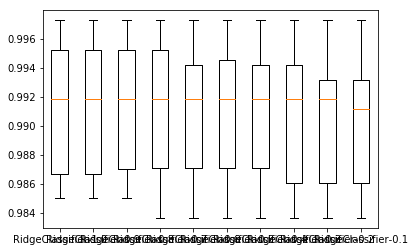

In [10]:
X, y = load_dataset()
models = define_models()
results = evaluate_models(X, y, models)
summarize_results(results, top_n=5)

Just to have a ranked list of all models, let's call again the `summarize_results` function but disabling the plotting option.

In [ ]:
summarize_results(results, top_n=len(results), plot=False)